In [2]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random

tf.random.set_seed(16)
np.random.seed(16)
random.seed(16)
print("Download Data")
try:
    dataframe = yf.download('^GSPC', start='2000-01-01', end='2023-12-31', progress=False)
    print("Dati scaricati con successo.")
except Exception as e:
    print(f"Errore durante il download dei dati: {e}")
    exit()

log_returns = np.log(dataframe['Close'] / dataframe['Close'].shift(1))
log_returns = log_returns.dropna()
log_returns = log_returns.squeeze() # ci assicura che sia una Series

data = log_returns.values
print(f"\nCaricati {len(data)} rendimenti giornalieri.")


sequence_lenth=60
step_size=1
dataset=[]
for i in range(0,len(data)-sequence_lenth+step_size):
    x=[]
    for j in range(sequence_lenth):
        x.append(data[j+i])
    dataset.append(x)

dataset=np.array(dataset)
dataset=dataset[...,np.newaxis]
min=dataset.min()
max=dataset.max()
dataset=2*(dataset-min)/(max-min)-1
print(dataset.min())
print(dataset.max())
train_sequence=dataset.astype('float32')

Download Data
Dati scaricati con successo.

Caricati 6036 rendimenti giornalieri.


/tmp/ipykernel_440/3512603047.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dataframe = yf.download('^GSPC', start='2000-01-01', end='2023-12-31', progress=False)


-1.0
1.0


In [3]:

G=tf.keras.Sequential([
    tf.keras.layers.Dense(units=1500,input_shape=(100,)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((15,100)),
    tf.keras.layers.Conv1DTranspose(filters=256,kernel_size=3,padding="same",strides=2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv1DTranspose(filters=1,kernel_size=3,activation="tanh",padding="same",strides=2),
])

G.summary()

D=tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128,kernel_size=3,padding="same",strides=2,input_shape=(60,1)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv1D(filters=256,kernel_size=3,padding="same",strides=2),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1)
])

D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1500)              151500    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1500)              0         
                                                                 
 reshape (Reshape)           (None, 15, 100)           0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 30, 256)           77056     
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30, 256)           0         
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 60, 1)             769       
 Transpose)                                             

In [4]:
from scipy.linalg import sqrtm

GP_WEIGHT=10.0 # Standard value for the Gradient Penalty weight
batch_size=256
epochs=50
latent_dim=100 
D_loss_mean=[]
G_loss_mean=[]
D_optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5,clipvalue=0.01)
G_optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001, beta_1=0.5,clipvalue=0.01)
dataset=tf.data.Dataset.from_tensor_slices(train_sequence).shuffle(len(train_sequence)).batch(batch_size,drop_remainder=True)

@tf.function
def Train_Step_WGANGP(real_sequence):
    batch_size=tf.shape(real_sequence)[0]

    noise=tf.random.normal(shape=(batch_size,latent_dim))

    with tf.GradientTape() as disc_tape:
        fake_sequence=G(noise,training=True)

        real_output=D(real_sequence,training=True)
        fake_output=D(fake_sequence,training=True)

        # Loss WGAN
        disc_wgan_loss=tf.reduce_mean(fake_output)-tf.reduce_mean(real_output)

        # Gradient Penalty
        alpha=tf.random.uniform(shape=[batch_size,1,1],minval=0.,maxval=1.)
        interpolated_sequence=alpha*real_sequence+(1-alpha)*fake_sequence

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_sequence)
            pred = D(interpolated_sequence, training=True)

        grads=gp_tape.gradient(pred,[interpolated_sequence])[0]
        norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2]))
        gradient_penalty=tf.reduce_mean((norm-1.0)**2)

        disc_loss=disc_wgan_loss+GP_WEIGHT*gradient_penalty

    D_Gradient=disc_tape.gradient(disc_loss,D.trainable_variables)
    D_optimizer.apply_gradients(zip(D_Gradient,D.trainable_variables))

    # traning G
    with tf.GradientTape() as gen_tape:
        noise=tf.random.normal(shape=(batch_size, latent_dim))
        fake_sequence=G(noise,training=True)
        fake_output=D(fake_sequence,training=True)

        # Loss del Generatore
        gen_loss=-tf.reduce_mean(fake_output)

    G_Gradient=gen_tape.gradient(gen_loss,G.trainable_variables)
    G_optimizer.apply_gradients(zip(G_Gradient,G.trainable_variables))

    return disc_loss,gen_loss
for epoch in range(epochs):
    epoch_d_loss=[]
    epoch_g_loss=[]

    for sequence_batch in dataset:
        d_loss, g_loss=Train_Step_WGANGP(sequence_batch)
        epoch_d_loss.append(d_loss.numpy())
        epoch_g_loss.append(g_loss.numpy())

    avg_d=np.mean(epoch_d_loss)
    avg_g=np.mean(epoch_g_loss)

    D_loss_mean.append(avg_d)
    G_loss_mean.append(avg_g)

    print(f"Epoch {epoch + 1}/{epochs} - D Loss: {avg_d:.4f}, G Loss: {avg_g:.4f}")




Epoch 1/50 - D Loss: 7.8676, G Loss: 0.0026
Epoch 2/50 - D Loss: 7.0164, G Loss: -0.0017
Epoch 3/50 - D Loss: 6.0578, G Loss: -0.0084
Epoch 4/50 - D Loss: 5.0427, G Loss: -0.0166
Epoch 5/50 - D Loss: 4.0146, G Loss: -0.0285
Epoch 6/50 - D Loss: 2.9775, G Loss: -0.0430
Epoch 7/50 - D Loss: 2.0044, G Loss: -0.0622
Epoch 8/50 - D Loss: 1.1656, G Loss: -0.0849
Epoch 9/50 - D Loss: 0.5649, G Loss: -0.1075
Epoch 10/50 - D Loss: 0.2479, G Loss: -0.1316
Epoch 11/50 - D Loss: 0.1255, G Loss: -0.1521
Epoch 12/50 - D Loss: 0.1082, G Loss: -0.1685
Epoch 13/50 - D Loss: 0.1066, G Loss: -0.1769
Epoch 14/50 - D Loss: 0.1113, G Loss: -0.1808
Epoch 15/50 - D Loss: 0.1204, G Loss: -0.1809
Epoch 16/50 - D Loss: 0.1226, G Loss: -0.1793
Epoch 17/50 - D Loss: 0.1265, G Loss: -0.1794
Epoch 18/50 - D Loss: 0.1311, G Loss: -0.1771
Epoch 19/50 - D Loss: 0.1312, G Loss: -0.1708
Epoch 20/50 - D Loss: 0.1348, G Loss: -0.1671
Epoch 21/50 - D Loss: 0.1362, G Loss: -0.1569
Epoch 22/50 - D Loss: 0.1374, G Loss: -0.151

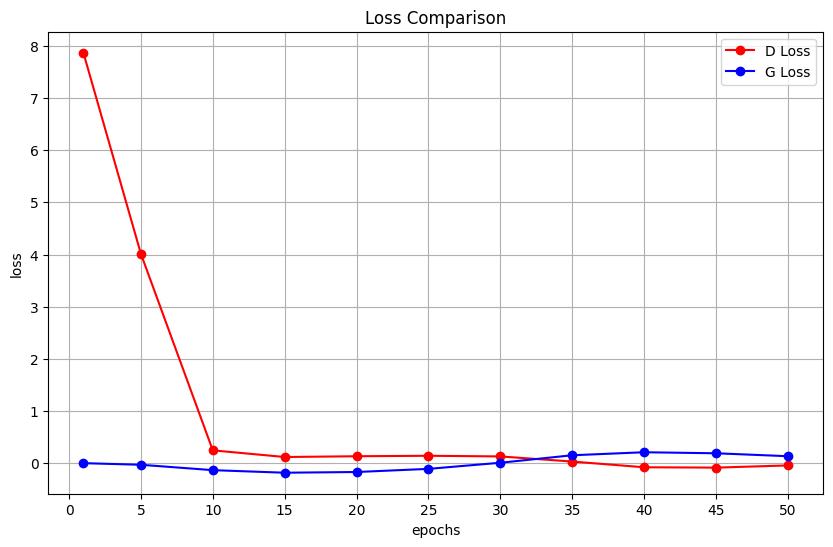

In [25]:
#plot of G and L mean loss for all epochs

plt.figure(figsize=(10,6))
xvalues=[1,5,10,15,20,25,30,35,40,45,50]
D_plot=[]
G_plot=[]
for el in xvalues:
    D_plot.append(D_loss_mean[el-1])
    G_plot.append(G_loss_mean[el-1])
plt.plot(xvalues,D_plot,"o-",label="D Loss",color="red")
plt.plot(xvalues,G_plot,"o-",label="G Loss",color="blue")
plt.legend()
plt.xticks(ticks=range(0,51,5))
plt.title("Loss Comparison")
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
print("D_loss value:")
for el in D_loss_mean:
    print(el)
print("G_loss value:")
for el in G_loss_mean:
    print(el)

D_loss value:
8.049492
7.1378036
5.9909024
4.7028184
3.4149947
2.2149184
1.1894048
0.44126362
0.036127403
-0.084884636
-0.06040863
-0.036626097
-0.027768299
-0.040133297
-0.06786458
-0.07535341
-0.07357271
-0.06628473
-0.06564271
-0.05517829
-0.043975353
-0.03591718
-0.027327022
-0.018149516
-0.007914775
0.0043286355
0.014891545
0.018354315
0.025460368
0.03561118
0.0358461
0.0411296
0.04551972
0.044709165
0.04460251
0.043391913
0.035947062
0.03243616
0.023121629
0.01232626
-0.0011168736
-0.012443869
-0.0327854
-0.051294103
-0.07114662
-0.08749229
-0.09934216
-0.100969255
-0.103035934
-0.09844924
G_loss value:
0.0077620177
0.015729455
0.02325687
0.030194659
0.034426536
0.035816453
0.02806735
0.013512797
-0.0067968187
-0.03457546
-0.055453792
-0.07506949
-0.07951329
-0.08400007
-0.087583005
-0.0950409
-0.10162284
-0.11175868
-0.122430064
-0.13326477
-0.14541106
-0.15107965
-0.16321394
-0.16804898
-0.17667265
-0.18210399
-0.18002404
-0.18146718
-0.17454709
-0.16917774
-0.16324401
-0.15145

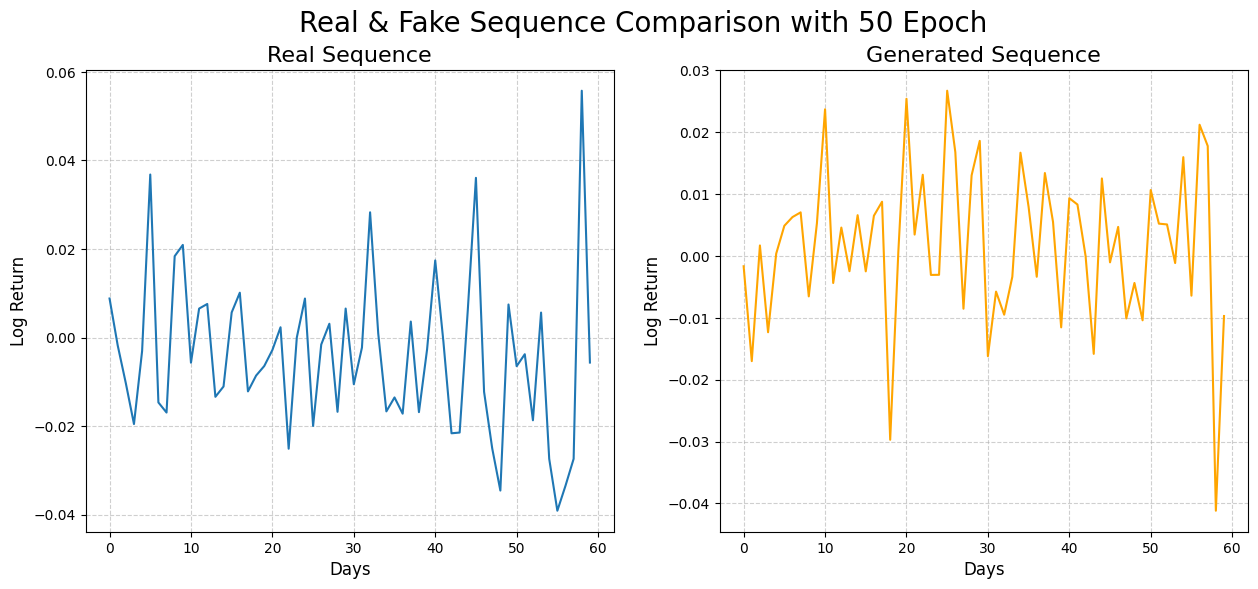

In [31]:

# Generiamo un batch di sequenze false
noise = tf.random.normal(shape=(1, latent_dim))
generated_sequence_normalized = G(noise, training=False)

# Estraiamo la prima (e unica) sequenza dal batch e la convertiamo in un array NumPy
# Rimuoviamo anche la dimensione del canale (l'ultima dimensione)
generated_sequence_normalized = generated_sequence_normalized.numpy().squeeze()

# De-normalizziamo la sequenza per riportarla alla scala originale
# Ricorda di usare le variabili min_val e max_val che hai calcolato prima!
# (Assicurati che si chiamino così nel tuo codice, altrimenti adatta i nomi)
generated_sequence_real = ((generated_sequence_normalized + 1) * (max - min) / 2) + min

# Ora plottiamo il risultato per un confronto visivo

# Scegliamo un campione reale a caso dal nostro dataset originale per il confronto
real_sample_index = np.random.randint(0, len(train_sequence))
real_sequence_normalized = train_sequence[real_sample_index].squeeze()
real_sequence_real = ((real_sequence_normalized + 1) * (max - min) / 2) + min

# Creiamo il grafico
plt.figure(figsize=(15, 6))

# Grafico della sequenza reale
plt.subplot(1, 2, 1)
plt.plot(real_sequence_real)
plt.title('Real Sequence', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Log Return', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Grafico della sequenza generata
plt.subplot(1, 2, 2)
plt.plot(generated_sequence_real, color='orange')
plt.title('Generated Sequence', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Log Return', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Real & Fake Sequence Comparison with 50 Epoch ', fontsize=20)
plt.show()

In [32]:
import pandas as pd

print(f"Media: {np.mean(real_sequence_real):.6f}  |   {np.mean(generated_sequence_real):.6f}")
print(f"Deviazione Standard: {np.std(real_sequence_real):.6f}  |   {np.std(generated_sequence_real):.6f}")

print(f"Eccesso di Curtosi: {pd.Series(real_sequence_real).kurtosis():.6f}  |  {pd.Series(generated_sequence_real).kurtosis():.6f}")

Media: -0.004167  |   0.001780
Deviazione Standard: 0.017681  |   0.012558
Eccesso di Curtosi: 1.495116  |  1.459760


Generazione di 5000 campioni dal Generatore...


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [01:39<00:00, 50.33it/s]


Mean:  0.000197  |   -0.000512
Standard Deviation:0.012379  |   0.010467
Excess Kurtosis: 10.283440  |   0.234558


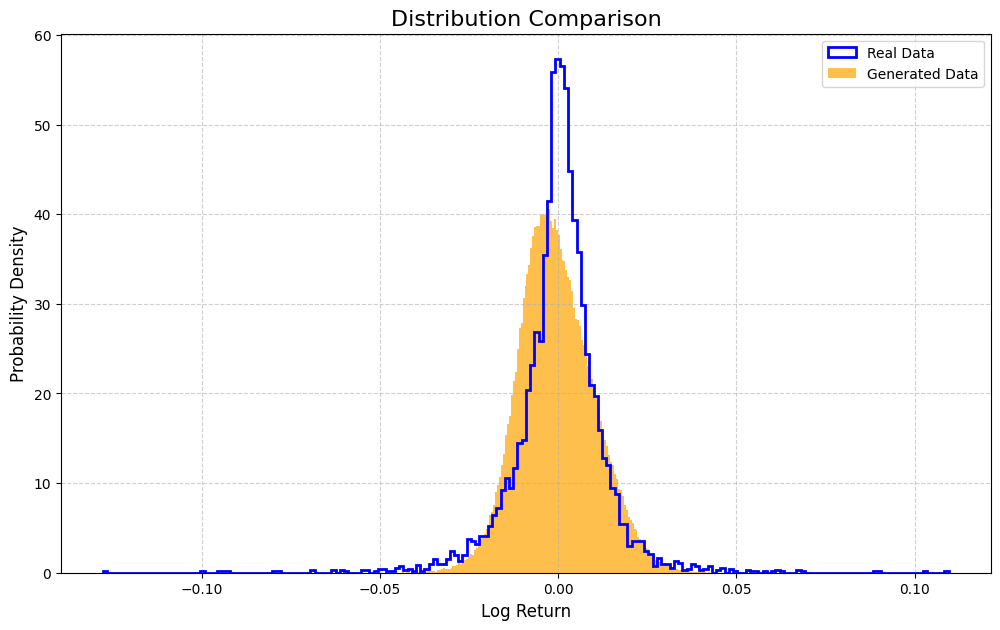

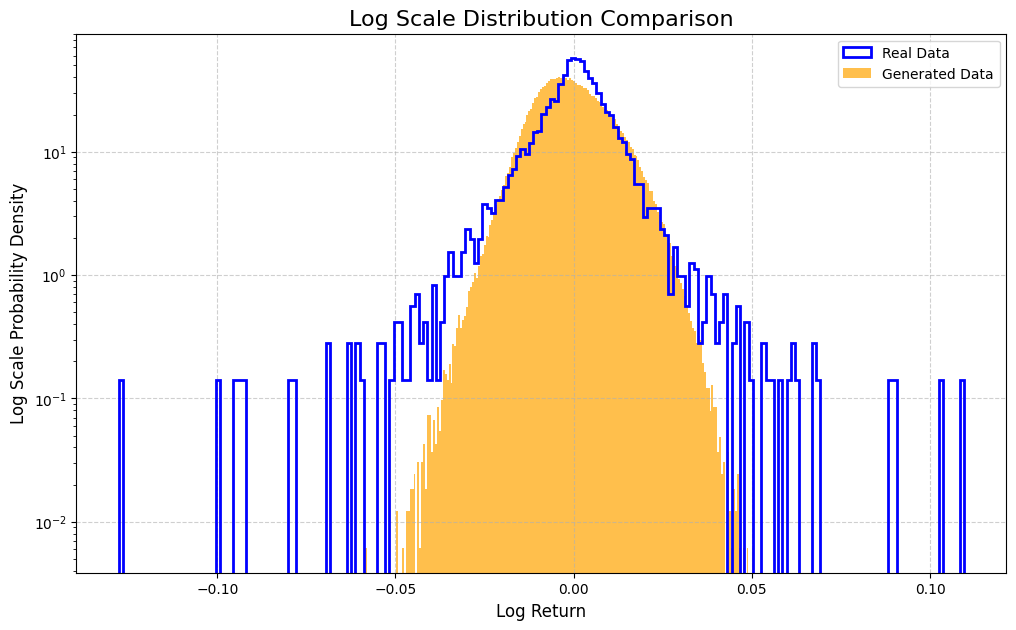

In [36]:

from tqdm import tqdm

NUM_SAMPLES = 5000  # Numero di sequenze da generare

all_generated_sequences = []

print(f"Generazione di {NUM_SAMPLES} campioni dal Generatore...")
for _ in tqdm(range(NUM_SAMPLES)):
    # 1. Crea rumore casuale
    noise = tf.random.normal(shape=(1, latent_dim))
    # 2. Genera una sequenza normalizzata
    generated_sequence_normalized = G(noise, training=False)
    # 3. Aggiungi la sequenza (in formato NumPy) alla lista
    all_generated_sequences.append(generated_sequence_normalized.numpy())

# Concatena tutte le sequenze in un unico grande array NumPy
# La forma sarà (5000, 60, 1)
generated_dataset_normalized = np.concatenate(all_generated_sequences)

generated_dataset_real=((generated_dataset_normalized+1)*(max-min)/2)+min    # denormalizzazione

# "Appiattisci" l'array per ottenere una singola serie di rendimenti giornalieri
# Questo trasforma l'array (5000, 60, 1) in (300000,)
generated_returns_flat = generated_dataset_real.flatten()

print(f"Mean:  {np.mean(data):.6f}  |   {np.mean(generated_returns_flat):.6f}")
print(f"Standard Deviation:{np.std(data):.6f}  |   {np.std(generated_returns_flat):.6f}")

import pandas as pd
print(f"Excess Kurtosis: {pd.Series(data).kurtosis():.6f}  |   {pd.Series(generated_returns_flat).kurtosis():.6f}")

# Grafico 1: Scala Lineare
plt.figure(figsize=(12, 7))
plt.hist(data, bins=200, density=True, label='Real Data', color='blue', histtype='step', linewidth=2)
plt.hist(generated_returns_flat, bins=200, density=True, label='Generated Data', color='orange', alpha=0.7)
plt.title('Distribution Comparison', fontsize=16)
plt.xlabel('Log Return', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Grafico 2: Scala Logaritmica (per le code grasse)
plt.figure(figsize=(12, 7))
plt.yscale('log') 
plt.hist(data, bins=200, density=True, label='Real Data', color='blue', histtype='step', linewidth=2)
plt.hist(generated_returns_flat, bins=200, density=True, label='Generated Data', color='orange', alpha=0.7)
plt.title('Log Scale Distribution Comparison', fontsize=16)
plt.xlabel('Log Return', fontsize=12)
plt.ylabel('Log Scale Probability Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()